In [1]:
import sys

sys.executable.split('/')[-3] == 'cda_venv'

True

In [2]:
import os
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from skmultiflow.drift_detection import ADWIN, DDM, EDDM, HDDM_A, HDDM_W, KSWIN, PageHinkley

sys.path.append('./')
from src.utils import *

warnings.filterwarnings('ignore')

## Paths handling

In [3]:
data_dir = 'dane'

series_1_file = 'series1.csv'
series_2_file = 'series2.csv'
series_3_file = 'series3.csv'

## Data loading

In [4]:
series_1 = pd.read_csv(os.path.join(data_dir, series_1_file))
series_2 = pd.read_csv(os.path.join(data_dir, series_2_file))
series_3 = pd.read_csv(os.path.join(data_dir, series_3_file))

## EDA

In [5]:
describe_df = pd.concat([
    pd.DataFrame(series_1.describe()), 
    pd.DataFrame(series_2.describe()), 
    pd.DataFrame(series_3.describe()), 
], axis=1)

describe_df.columns = [
    'series_1',
    'series_2',
    'series_3'
]

describe_df

series_1      series_2      series_3
count  10000.000000  10000.000000  10000.000000
mean       1.560164      1.218998      0.341367
std        0.451253      0.343128      0.760687
min        0.027671      0.260772     -2.590082
25%        1.236303      0.960094     -0.175291
50%        1.534117      1.187897      0.338872
75%        1.870704      1.460557      0.866510
max        3.117181      2.485598      3.062030

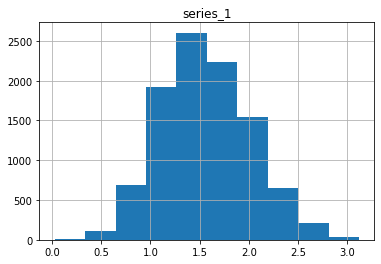

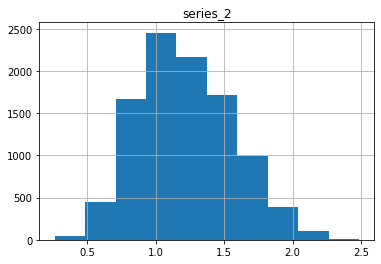

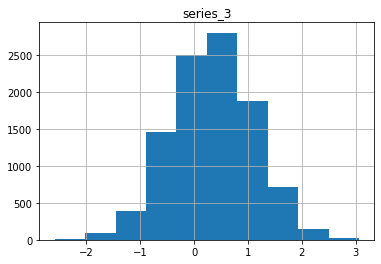

In [6]:
series_1.rename(columns={'x': 'series_1'}).hist()
series_2.rename(columns={'x': 'series_2'}).hist()
series_3.rename(columns={'x': 'series_3'}).hist()
pass

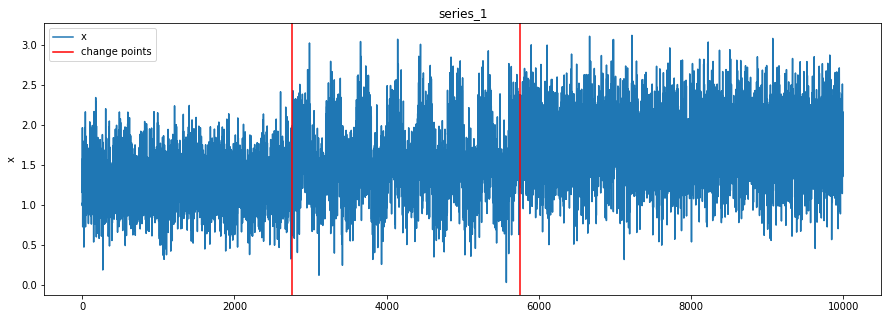

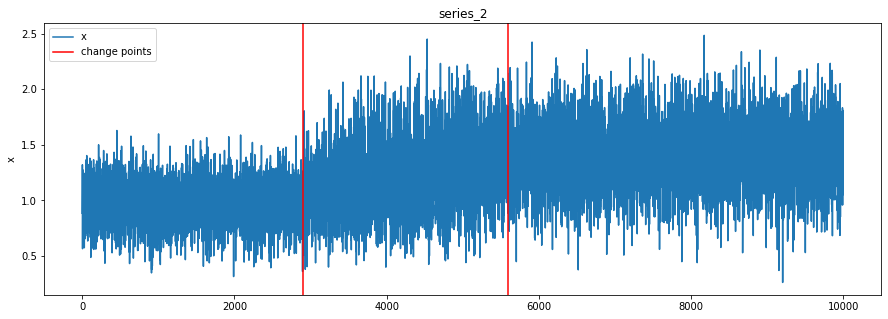

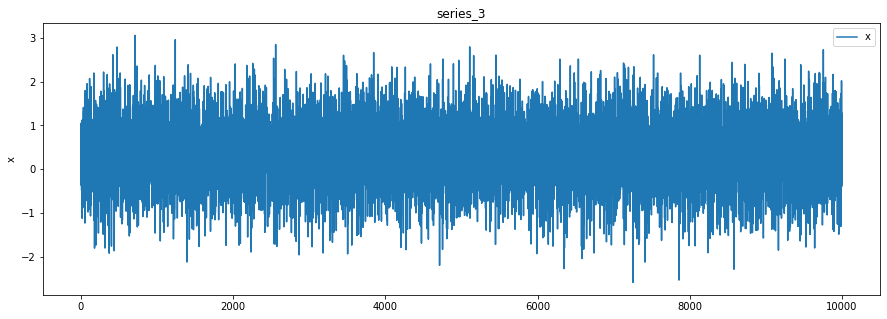

In [7]:
change_points_1 = [2750, 5750]
plot_data(
    series_1,
    change_points=change_points_1,
    title='series_1'
)

change_points_2 = [2900, 5600]
plot_data(
    series_2,
    change_points=change_points_2,
    title='series_2'
)

change_points_3 = []
plot_data(
    series_3,
    change_points=change_points_3,
    title='series_3'
)

## Used concept drift detection methods (descriptions from [scikit-multiflow docs](https://scikit-multiflow.readthedocs.io/en/stable/api/api.html)):


___
### ADWIN
ADWIN (ADaptive WINdowing) is an adaptive sliding window algorithm for detecting change, and keeping updated statistics about a data stream. ADWIN allows algorithms not adapted for drifting data, to be resistant to this phenomenon.

The general idea is to keep statistics from a window of variable size while detecting concept drift.

The algorithm will decide the size of the window by cutting the statistics’ window at different points and analysing the average of some statistic over these two windows. If the absolute value of the difference between the two averages surpasses a pre-defined threshold, change is detected at that point and all data before that time is discarded.

___
### DDM
DDM (Drift Detection Method) is a concept change detection method based on the PAC learning model premise, that the learner’s error rate will decrease as the number of analysed samples increase, as long as the data distribution is stationary.

If the algorithm detects an increase in the error rate, that surpasses a calculated threshold, either change is detected or the algorithm will warn the user that change may occur in the near future, which is called the warning zone.

The detection threshold is calculated in function of two statistics, obtained when (pi + si) is minimum:

$p_{min}$: The minimum recorded error rate.

$s_{min}$: The minimum recorded standard deviation.

At instant $i$, the detection algorithm uses:
- $p_i$: The error rate at instant i.
- $s_i$: The standard deviation at instant i.

The conditions for entering the warning zone and detecting change are as follows:
- if $ p_i + s_i ≥ p_{min} + 2*s_(min} $ -> Warning zone
- if $ p_i + s_i ≥ p_{min} + 3*s_(min} $ -> Change detected

___
### EDDM
EDDM (Early Drift Detection Method) [1] aims to improve the detection rate of gradual concept drift in DDM, while keeping a good performance against abrupt concept drift.

This method works by keeping track of the average distance between two errors instead of only the error rate. For this, it is necessary to keep track of the running average distance and the running standard deviation, as well as the maximum distance and the maximum standard deviation.

The algorithm works similarly to the DDM algorithm, by keeping track of statistics only. It works with the running average distance (p_i^') and the running standard deviation (s_i^'), as well as p^'_{max} and s^'_{max}, which are the values of p_i^' and s_i^' when (p_i^' + 2 * s_i^') reaches its maximum.

Like DDM, there are two threshold values that define the borderline between no change, warning zone, and drift detected. These are as follows:

- if $(p_i^' + 2 * s_i^')/(p^'_{max} + 2 * s^'_{max}) < lpha$ -> Warning zone
- if $(p_i^' + 2 * s_i^')/(p^'_{max} + 2 * s^'_{max}) < eta$ -> Change detected

$lpha$ and $eta$ are set to 0.95 and 0.9, respectively.

___
### HDDM_A
HDDM_A is a drift detection method based on the Hoeffding’s inequality. HDDM_A uses the average as estimator. It receives as input a stream of real values and returns the estimated status of the stream: STABLE, WARNING or DRIFT.

Implementation based on MOA.
___
### HDDM_W
HDDM_W is an online drift detection method based on McDiarmid’s bounds. HDDM_W uses the EWMA statistic as estimator. It receives as input a stream of real predictions and returns the estimated status of the stream: STABLE, WARNING or DRIFT.

Implementation based on MOA.

___
### KSWIN
KSWIN (Kolmogorov-Smirnov Windowing) is a concept change detection method based on the Kolmogorov-Smirnov (KS) statistical test. KS-test is a statistical test with no assumption of underlying data distribution. KSWIN can monitor data or performance distributions. Note that the detector accepts one dimensional input as array.

KSWIN maintains a sliding window $Ψ$ of fixed size $n$ (window_size). The last $r$ (stat_size) samples of $Ψ$ are assumed to represent the last concept considered as $R$. From the first $n − r$ samples of $Ψ$, $r$ samples are uniformly drawn, representing an approximated last concept $W$.

The KS-test is performed on the windows $R$ and $W$ of the same size. KS -test compares the distance of the empirical cumulative data distribution $dist(R, W)$

A concept drift is detected by KSWIN if:
- $dist(R,W) > \sqrt{−\frac{lnα}{r}}$ -> The difference in empirical data distributions between the windows $R$ and $W$ is too large as that R and W come from the same distribution.
___
### PageHinkley
This change detection method works by computing the observed values and their mean up to the current moment. Page-Hinkley won’t output warning zone warnings, only change detections. The method works by means of the Page-Hinkley test. In general lines it will detect a concept drift if the observed mean at some instant is greater then a threshold value lambda.

## Series 1

### Concept drift detection methods on `series_1`

In [8]:
data = series_1
cd_methods_dict = get_cd_methods()
concept_drift_detections = {}
verbose=True

for cd_method_name, cd_method in cd_methods_dict.items():
    warning_zones, change_points = drift_detection(
        data=data,
        cd_method=cd_method, 
        verbose=verbose
    )
    concept_drift_detections[cd_method_name] = {}
    concept_drift_detections[cd_method_name]['warning_zones'] = warning_zones
    concept_drift_detections[cd_method_name]['change_points'] = change_points

========================= Method: ADWIN =========================
Change has been detected: 1.40454019740779 - of index: 3007
Change has been detected: 2.26367419316964 - of index: 3327
Change has been detected: 1.47067114309803 - of index: 3359
Change has been detected: 1.46951985195725 - of index: 3455
Change has been detected: 1.04155997255274 - of index: 3519
Change has been detected: 2.22150681018205 - of index: 3711
Change has been detected: 1.22649382165417 - of index: 4479
Change has been detected: 1.32665396781721 - of index: 4927
Change has been detected: 1.96548810371677 - of index: 5695
Change has been detected: 2.27856974145354 - of index: 5887
Change has been detected: 1.57344302357862 - of index: 5951
Change has been detected: 1.87370071142426 - of index: 6271
Change has been detected: 1.61358264023167 - of index: 7999

========================= Method: DDM =========================

========================= Method: EDDM =========================

======================

### Concept drift detections (red) and warning zones (orange) on `series_1`

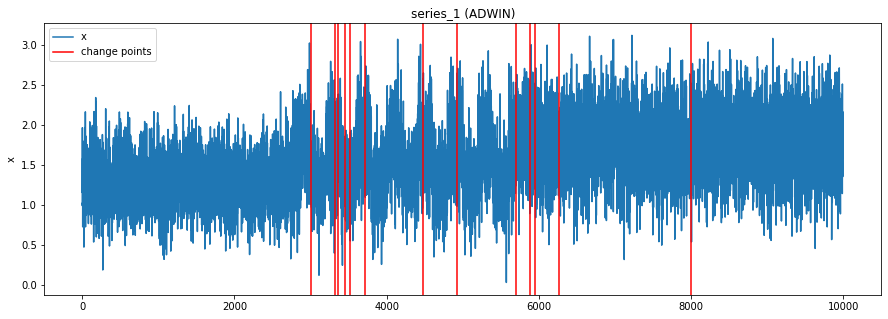

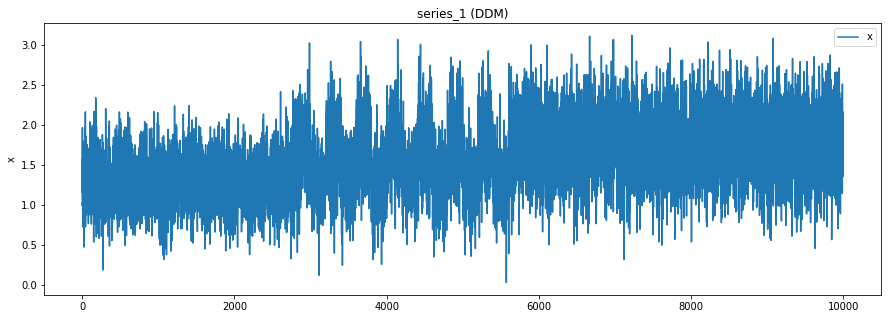

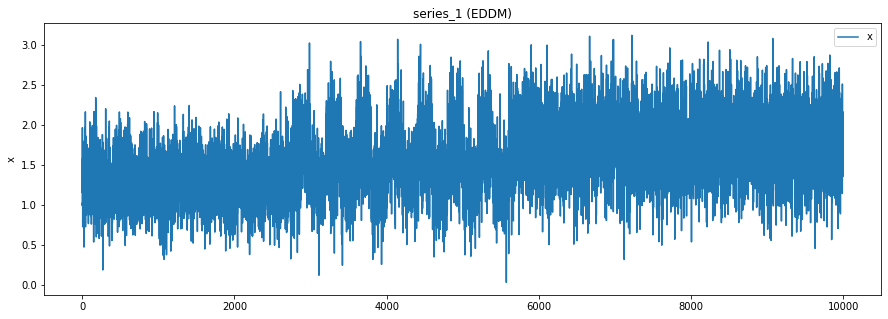

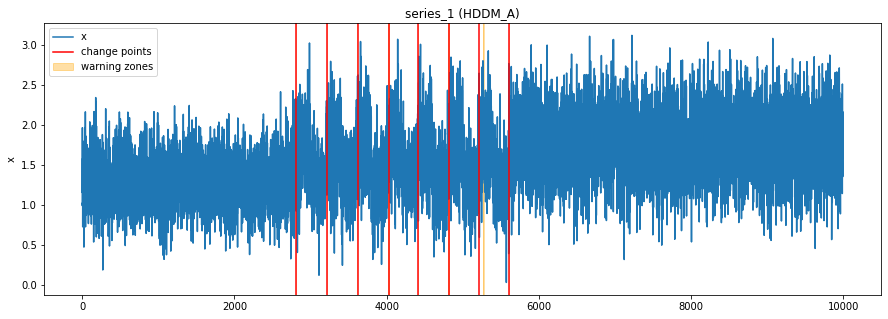

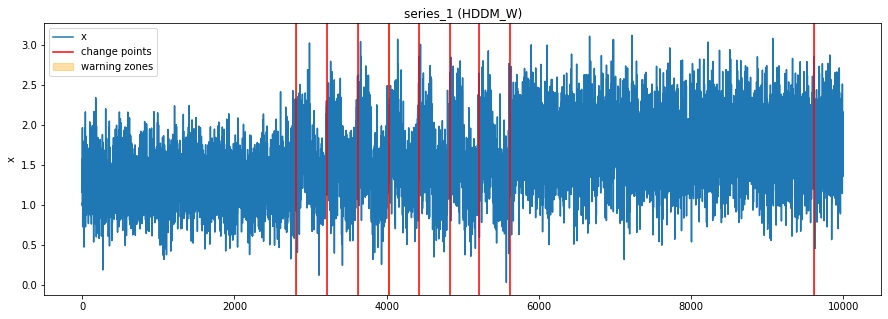

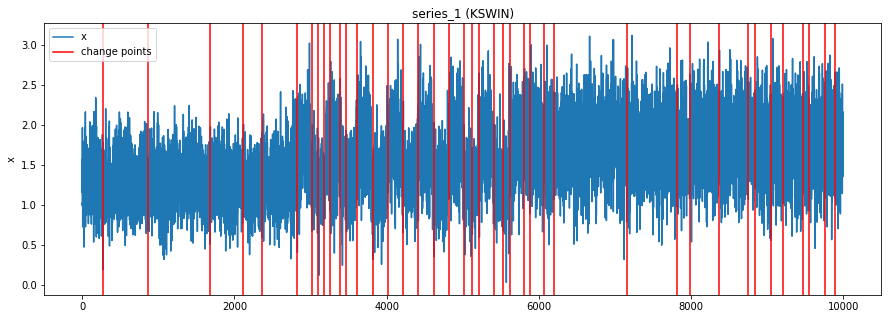

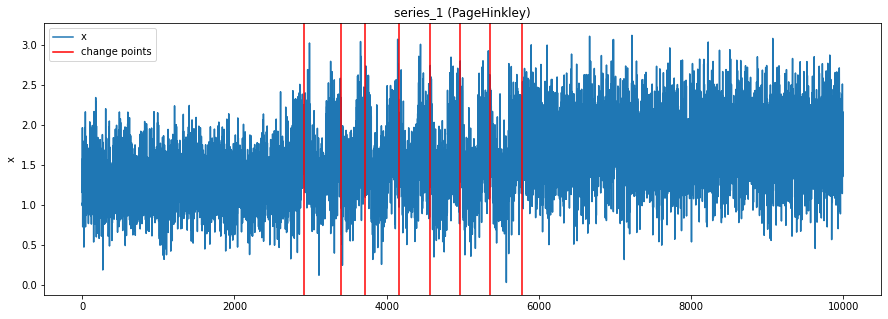

In [9]:
data = series_1

for cd_method_name in cd_methods_dict.keys():
    warning_zones = concept_drift_detections[cd_method_name]['warning_zones']
    change_points = concept_drift_detections[cd_method_name]['change_points']
    plot_data(
        data,
        warning_zones=warning_zones, 
        change_points=change_points,
        title=f'series_1 ({cd_method_name})'
    )

## Series 2

### Concept drift detection methods on `series_2`

In [10]:
data = series_2
cd_methods_dict = get_cd_methods()
concept_drift_detections = {}
verbose=True

for cd_method_name, cd_method in cd_methods_dict.items():
    warning_zones, change_points = drift_detection(
        data=data,
        cd_method=cd_method, 
        verbose=verbose
    )
    concept_drift_detections[cd_method_name] = {}
    concept_drift_detections[cd_method_name]['warning_zones'] = warning_zones
    concept_drift_detections[cd_method_name]['change_points'] = change_points

ne has been detected: 1.74592011860475 - of index: 8102
Warning zone has been detected: 1.49308846664858 - of index: 8103
Warning zone has been detected: 1.43900508911786 - of index: 8104
Warning zone has been detected: 1.34327427979657 - of index: 8105
Warning zone has been detected: 2.053038953046 - of index: 8106
Warning zone has been detected: 1.54918396819901 - of index: 8107
Warning zone has been detected: 1.19739288633729 - of index: 8108
Warning zone has been detected: 1.30163800861251 - of index: 8109
Warning zone has been detected: 1.72468131529583 - of index: 8110
Warning zone has been detected: 1.33995707872474 - of index: 8111
Warning zone has been detected: 1.29360625155445 - of index: 8112
Warning zone has been detected: 1.79550381743154 - of index: 8113
Warning zone has been detected: 1.43113473038656 - of index: 8114
Warning zone has been detected: 1.31530697189323 - of index: 8115
Warning zone has been detected: 1.86148777578738 - of index: 8116
Warning zone has been 

### Concept drift detections (red) and warning zones (orange) on `series_2`

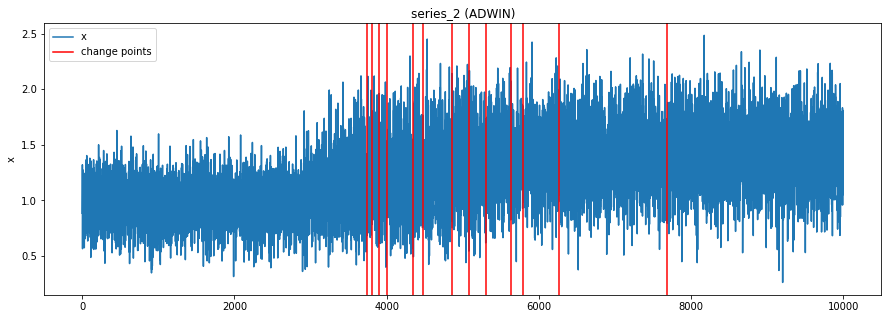

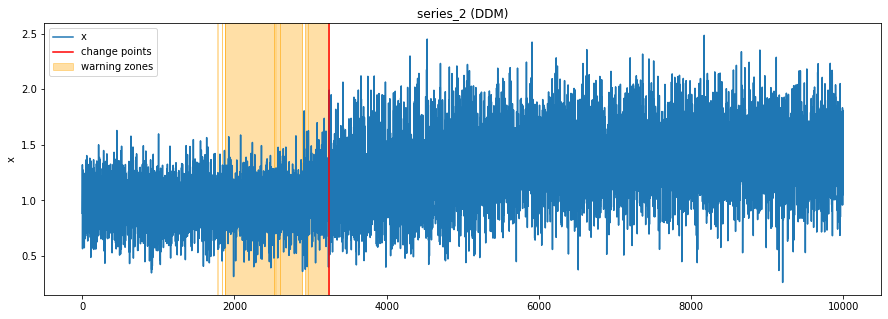

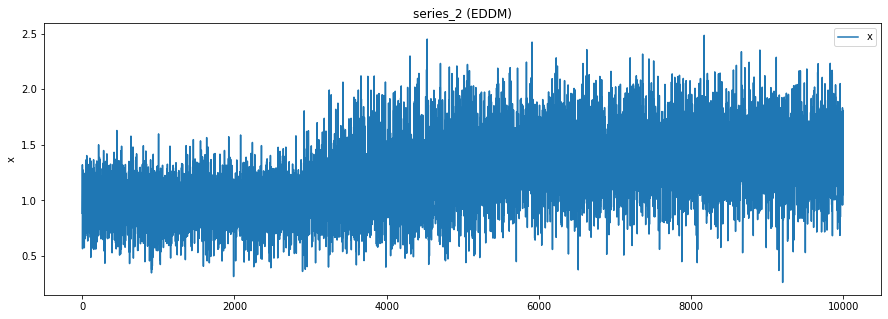

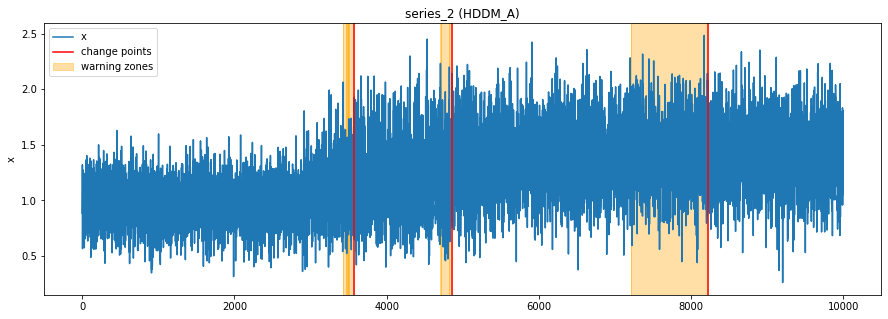

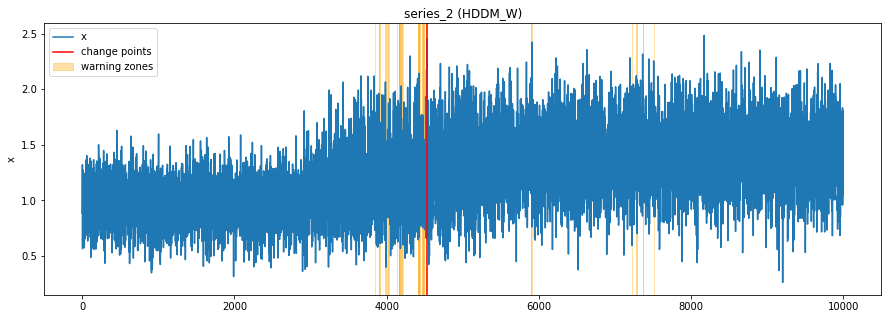

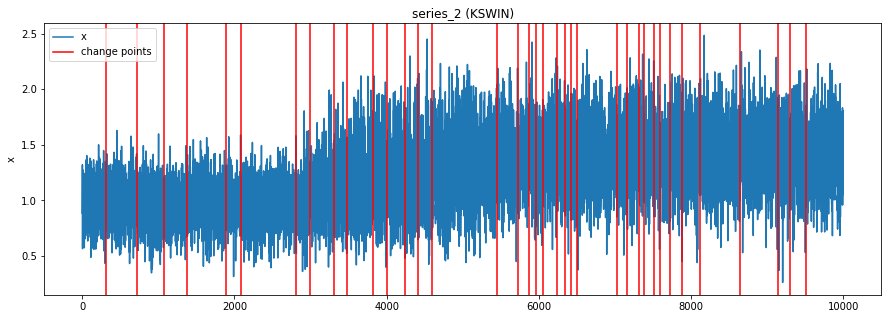

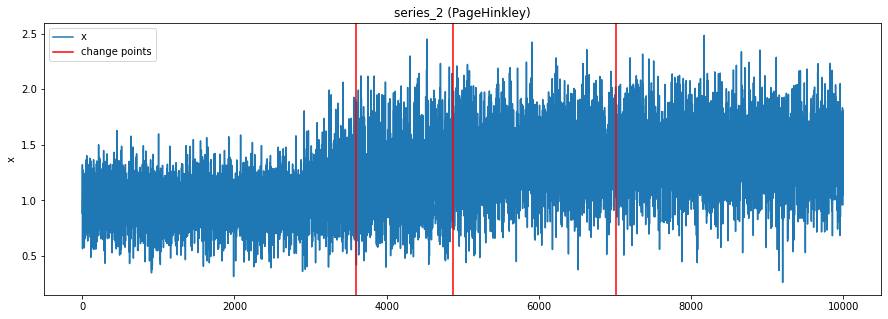

In [11]:
data = series_2

for cd_method_name in cd_methods_dict.keys():
    warning_zones = concept_drift_detections[cd_method_name]['warning_zones']
    change_points = concept_drift_detections[cd_method_name]['change_points']
    plot_data(
        data,
        warning_zones=warning_zones, 
        change_points=change_points,
        title=f'series_2 ({cd_method_name})'
    )

## Series 3

### Concept drift detection methods on `series_3`

In [12]:
data = series_3
cd_methods_dict = get_cd_methods()
concept_drift_detections = {}
verbose=True

for cd_method_name, cd_method in cd_methods_dict.items():
    warning_zones, change_points = drift_detection(
        data=data,
        cd_method=cd_method, 
        verbose=verbose
    )
    concept_drift_detections[cd_method_name] = {}
    concept_drift_detections[cd_method_name]['warning_zones'] = warning_zones
    concept_drift_detections[cd_method_name]['change_points'] = change_points

ndex: 3489
Warning zone has been detected: 0.620218864658915 - of index: 3490
Warning zone has been detected: 2.03840983280664 - of index: 3496
Warning zone has been detected: 0.903980364605227 - of index: 3578
Warning zone has been detected: 0.77753051876634 - of index: 3579
Change has been detected: 1.25223784152011 - of index: 3580
Change has been detected: 2.02756434398755 - of index: 3792
Warning zone has been detected: 1.63260135289966 - of index: 3805
Warning zone has been detected: 1.35934939605022 - of index: 3807
Warning zone has been detected: 0.246568145033446 - of index: 3808
Warning zone has been detected: 0.71121988659233 - of index: 3809
Warning zone has been detected: 2.06768306059183 - of index: 3825
Warning zone has been detected: 1.00423541582558 - of index: 3826
Warning zone has been detected: -1.08120898002722 - of index: 3827
Warning zone has been detected: 0.935939465750026 - of index: 3828
Warning zone has been detected: 1.35455385372459 - of index: 3830
Warnin

### Concept drift detections (red) and warning zones (orange) on `series_3`

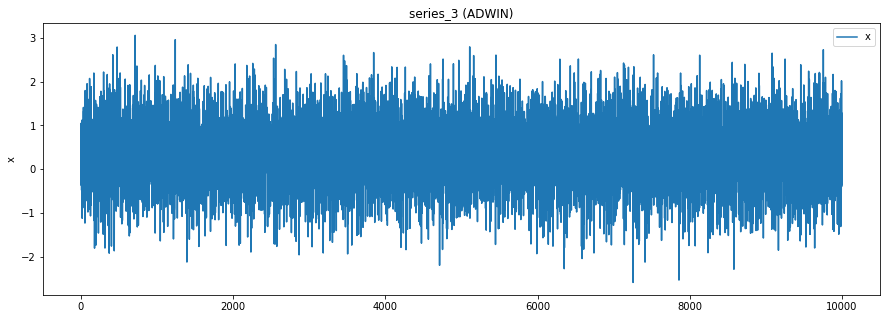

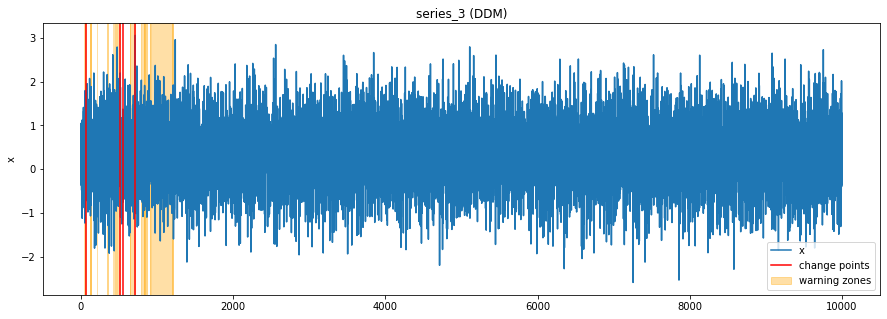

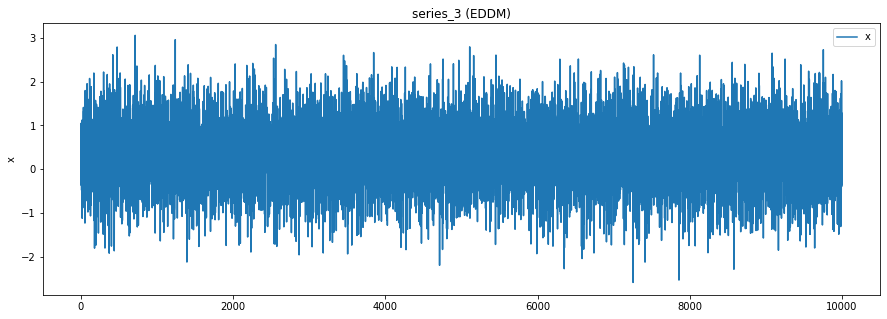

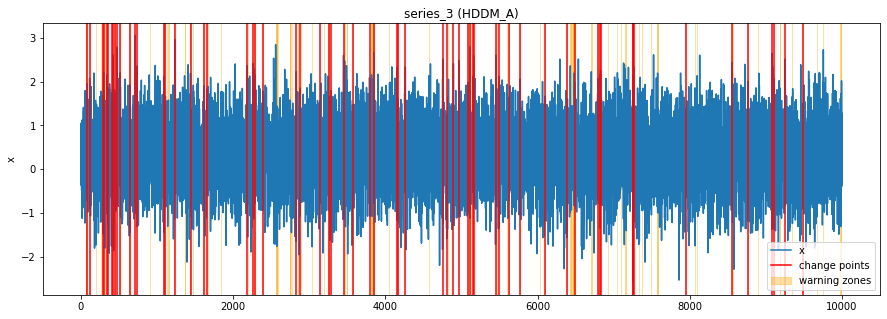

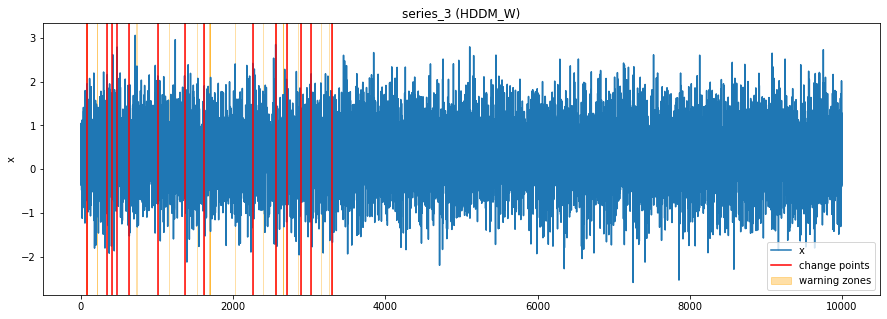

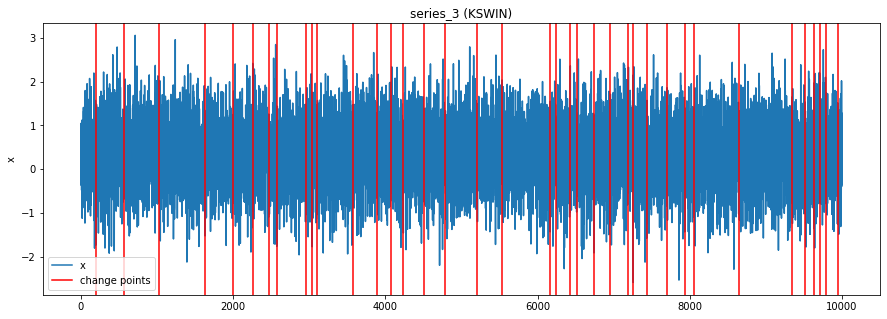

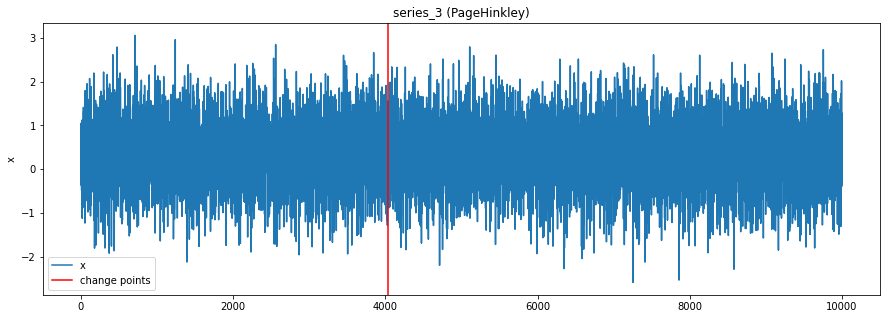

In [13]:
data = series_3

for cd_method_name in cd_methods_dict.keys():
    warning_zones = concept_drift_detections[cd_method_name]['warning_zones']
    change_points = concept_drift_detections[cd_method_name]['change_points']
    plot_data(
        data,
        warning_zones=warning_zones, 
        change_points=change_points,
        title=f'series_3 ({cd_method_name})'
    )

## Podsumowanie

Dołączone pliki `.csv` w folderze `dane/` zawierają po 10 tysięcy instancji wartości numerycznych pochodzących z pewnych rozkładów - każdy plik pochodzi z innego generatora.

Wizualizacja danych wskazuje na różne charakterystyki poszczególnych zestawów:
- w pierwszym zestawie zmiany są nagłe
- w drugim zestawie zmiany są narastająca
- natomiast w trzecim zestawie nie ma zauważalnych zmian

Analiza 3 podstawowo zróżnicowanych zestawów danych, za pomocą metod do wykrywania concept drift przygotowanych w bibliotece `scikit-multiflow`, wskazuje, że nie istnieje jedno dobre i uniwersalne rozwiązanie tego problemu. Żadna z przebadanych 7 metod nie poradziła sobie ze wskaaniem właściwych odczytów dla każdego zbioru. Ogólnym wnioskiem może być rówmnież stwierdzenie, że wykrywanie concept driftu nie jest prostym zadaniem, a stosowanie istniejących metod wymaga szczególnej weryfikacji.

Metody, które wskazały wyniki dobre lub stosunkowo dobre na poszczególnych zestawach danych:
- `series1.csv`
    - HDDM_A, HDDM_W, PageHinkley
- `series2.csv`
    - HDDM_A, PageHinkley
- `series3.csv`
    - ADWIN, EDDM